In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
dados = pd.read_csv('C:/Users/pedro/Downloads/test1 - Respostas ao formulário 1.csv')

In [3]:
dados.columns

Index(['Carimbo de data/hora', 'Seu e-mail?', 'Quantos anos você tem?',
       'Em que região você mora?',
       'De 1 a 5 o quanto que você gosta de futebol? (5 para muito, 1 para pouco)',
       'Você torce para algum time de futebol?',
       'Qual seu modo preferido de assistir a um jogo de futebol?',
       'Quantos jogos você costuma assistir por mês?',
       'De 1 a 5 o quanto você se empenha para completar o álbum? ',
       'De 1 a 5 o quanto você gosta de jogar futebol?',
       'Quantos álbums da copa do mundo você já completou?'],
      dtype='object')

In [4]:
colunas_ordinais = ['De 1 a 5 o quanto que você gosta de futebol? (5 para muito, 1 para pouco)',
                   'De 1 a 5 o quanto você se empenha para completar o álbum? ',
                   'De 1 a 5 o quanto você gosta de jogar futebol?']

colunas_nominais = ['Em que região você mora?',
                    'Você torce para algum time de futebol?',
                   'Qual seu modo preferido de assistir a um jogo de futebol?']

colunas_numericas = ['Quantos anos você tem?',
                     'Quantos jogos você costuma assistir por mês?',
                     'Quantos álbums da copa do mundo você já completou?']

cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, colunas_numericas),
    ('cat', cat_pipeline, colunas_ordinais+colunas_nominais)
])

In [5]:
X_train = dados.copy()
X_train.drop(columns=['Seu e-mail?', 'Carimbo de data/hora'], axis=1, inplace=True)

In [6]:
X_train_prepared = full_pipeline.fit_transform(X_train)

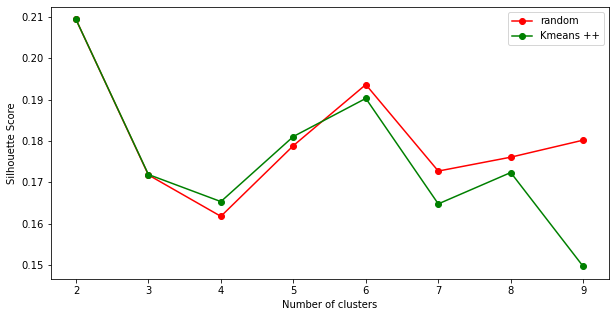

In [7]:
silhoute = []
silhoutemais = []

for clusters in range(2,10):
    km = KMeans(n_clusters = clusters, init='random', max_iter=300,random_state=42)
    km.fit(X_train_prepared)
    labels = km.labels_
    silh = silhouette_score(X_train_prepared, labels)
    silhoute.append(silh)
    
for clusters in range(2,10):
    kmm = KMeans(n_clusters = clusters, init ='k-means++', max_iter=300,random_state=42)
    kmm.fit(X_train_prepared)
    labelsm = kmm.labels_
    silhm = silhouette_score(X_train_prepared, labelsm)
    silhoutemais.append(silhm)
    
#plotting the values
plt.figure(figsize=(10,5))
plt.plot(range(2, 10), silhoute, marker='o', color='r', label='random')
plt.plot(range(2, 10), silhoutemais, marker='o', color='g', label='Kmeans ++')
plt.legend(loc="upper right")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='comp_1', ylabel='comp_2'>

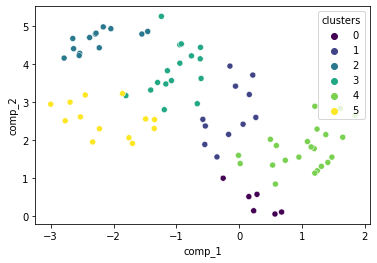

In [8]:
model = TSNE(n_components=2, random_state=42, perplexity=50)
principal_comp = model.fit_transform(X_train_prepared)
tsne_dataframe = pd.DataFrame(data = principal_comp,columns = ['comp_1','comp_2'])

km = KMeans(n_clusters = 6, init ='random', max_iter=300,random_state=42)
km.fit(X_train_prepared)
labels = km.labels_
tsne_dataframe['clusters'] = labels
X_train['clusters'] = labels
dados['clusters'] = labels

sns.scatterplot(x='comp_1', y='comp_2', hue='clusters', data=tsne_dataframe, palette='viridis')

In [9]:
filename = 'finalized_model.sav'
pickle.dump(km, open(filename, 'wb'))

In [10]:
loaded_model = pickle.load(open(filename, 'rb'))

In [11]:
def recomendando_amigos(usuario):
    usuario_prepared = full_pipeline.transform(usuario)
    y = loaded_model.predict(usuario_prepared)[0]
    amigos = dados.loc[dados['clusters']==y].sample(n=3)
    print('AMIGOS RECOMENDADOS: ')
    return amigos

In [12]:
teste = X_train.sample(n=1)

In [13]:
teste

,Quantos anos você tem?,Em que região você mora?,"De 1 a 5 o quanto que você gosta de futebol? (5 para muito, 1 para pouco)",Você torce para algum time de futebol?,Qual seu modo preferido de assistir a um jogo de futebol?,Quantos jogos você costuma assistir por mês?,De 1 a 5 o quanto você se empenha para completar o álbum?,De 1 a 5 o quanto você gosta de jogar futebol?,Quantos álbums da copa do mundo você já completou?,clusters
38,32,Norte,5,Sim,Ir ao estádio,23,5,5,4,4


In [14]:
recomendando_amigos(teste)

AMIGOS RECOMENDADOS: 


,Carimbo de data/hora,Seu e-mail?,Quantos anos você tem?,Em que região você mora?,"De 1 a 5 o quanto que você gosta de futebol? (5 para muito, 1 para pouco)",Você torce para algum time de futebol?,Qual seu modo preferido de assistir a um jogo de futebol?,Quantos jogos você costuma assistir por mês?,De 1 a 5 o quanto você se empenha para completar o álbum?,De 1 a 5 o quanto você gosta de jogar futebol?,Quantos álbums da copa do mundo você já completou?,clusters
40,28/10/2022 10:42:08,x@gmail.com,27,Sul,5,Sim,Ir ao estádio,24,5,5,3,4
53,28/10/2022 10:58:41,asdfqwf@gmail.com,12,Centro-Oeste,5,Sim,Em casa,15,5,5,1,4
39,28/10/2022 10:41:50,z@gmail.com,25,Nordeste,5,Sim,Ir ao estádio,18,5,4,3,4
